In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

%matplotlib widget

In [6]:
from struct import *
import numpy as np

def ucitaj_mnist(putanja):
    with open(putanja, "rb") as fp:
        magic_number = unpack(">I", fp.read(4))
        broj_slika = unpack(">I", fp.read(4))[0]
        broj_redova = unpack(">I", fp.read(4))[0]
        broj_kolona = unpack(">I", fp.read(4))[0]
        
        slike = np.frombuffer(fp.read(broj_slika*broj_redova*broj_kolona), dtype=np.uint8).reshape((broj_slika, broj_redova, broj_kolona))
        slike = slike.astype(np.float32)/255
        return slike

def ucitaj_mnist_labele(putanja):
    with open(putanja, "rb") as fp:
        magic_number = unpack(">I", fp.read(4))
        broj_labela = unpack(">I", fp.read(4))[0]
        labele = np.frombuffer(fp.read(broj_labela), dtype=np.uint8)
        return labele
    
slike_trening = ucitaj_mnist("train-images.idx3-ubyte")
labele_trening = ucitaj_mnist_labele("train-labels.idx1-ubyte")

slike_test = ucitaj_mnist("train-images.idx3-ubyte")
labele_test = ucitaj_mnist_labele("train-labels.idx1-ubyte")

In [77]:
class MnistDataset(Dataset):
    def __init__(self, putanja_podaci, putanja_label):
        super().__init__()
        
        self.slike_cifara = ucitaj_mnist(putanja_podaci)
        self.labele_cifara = ucitaj_mnist_labele(putanja_label)
        self.napravi_veliku_sliku()
        
    def napravi_veliku_sliku(self):
        slike = []
        labele = []
        
        for i in range(1000):
            velika_slika = np.zeros((1, 100, 100), dtype=np.float32)
            labela = -1*np.ones((10, 100, 100), dtype=np.float32)
            
            cifre = np.random.choice(len(self.slike_cifara), 3)
            koordinate = np.random.randint(0, 100-28, size=(3, 2))
            
            for j, s in enumerate(cifre):
                velika_slika[0][koordinate[j][0]:koordinate[j][0]+28,koordinate[j][1]:koordinate[j][1]+28] = self.slike_cifara[s]
                labela[self.labele_cifara[s]][koordinate[j][0]:koordinate[j][0]+28,koordinate[j][1]:koordinate[j][1]+28] = 1
            slike.append(velika_slika)
            labele.append(labela)
            
        self.podaci = list(zip(slike, labele))
    
    def __len__(self):
        return len(self.podaci)
    
    def __getitem__(self, indeks):
        return self.podaci[indeks]

In [78]:
mnist_podaci = MnistDataset("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
mnist_podaci2 = MnistDataset("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

In [79]:
mnist_trening_podaci = DataLoader(mnist_podaci, batch_size=4, shuffle=True)
mnist_test_podaci = DataLoader(mnist_podaci2, batch_size=4, shuffle=True)

In [80]:
class Mreza(nn.Module):
    def __init__(self):
        super(Mreza, self).__init__()
        self.sloj1 = nn.Conv2d(1, 100, 3, padding=1)
        self.sloj2 = nn.Conv2d(100, 50, 3, padding=1)
        self.sloj3 = nn.Conv2d(50, 25, 3, padding=1)
        self.sloj4 = nn.Conv2d(25, 15, 3, padding=1)
        # self.sloj5 = nn.Conv2d(15, 10, 3, padding=1)
        self.sloj6 = nn.Conv2d(15, 10, 3, padding=1)
    
    def forward(self, x):
        sloj1_rez = self.sloj1(x)
        sloj2_rez = self.sloj2(sloj1_rez)
        sloj3_rez = self.sloj3(sloj2_rez)
        sloj4_rez = self.sloj4(sloj3_rez)
        # sloj5_rez = self.sloj5(sloj4_rez)
        return F.tanh(self.sloj6(sloj4_rez))

In [94]:
mreza = Mreza()

funkcija_greske = nn.MSELoss()
optimizer = torch.optim.SGD(mreza.parameters(), lr=0.001, momentum=0.9)

for epoha in range(10):
    print(epoha)
    for (x, y) in mnist_trening_podaci:
        predikcija = mreza(x)
        optimizer.zero_grad()
        greska = funkcija_greske(predikcija, y)
        greska.backward()
        optimizer.step()

0
1
2
3
4
5
6
7
8
9


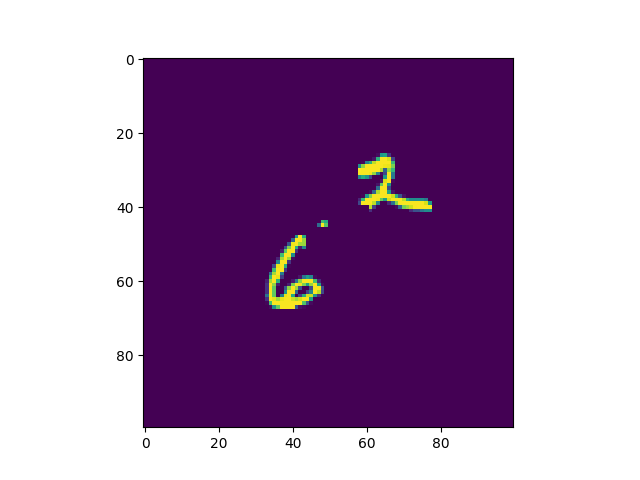

In [95]:
with torch.no_grad():
    primer = next(iter(mnist_test_podaci))
    plt.figure()
    plt.imshow(primer[0][1][0])
    plt.show()

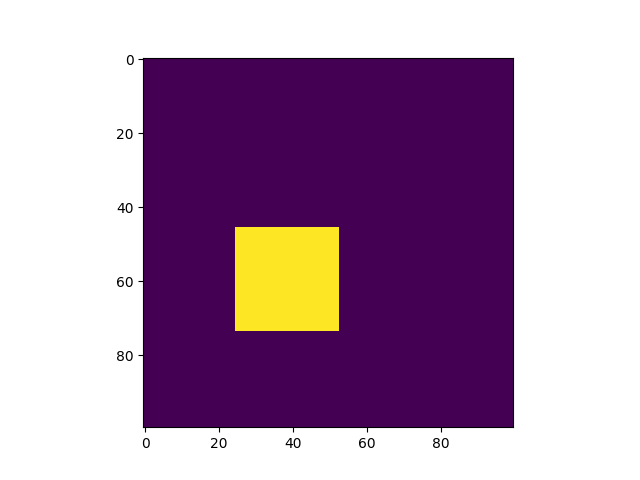

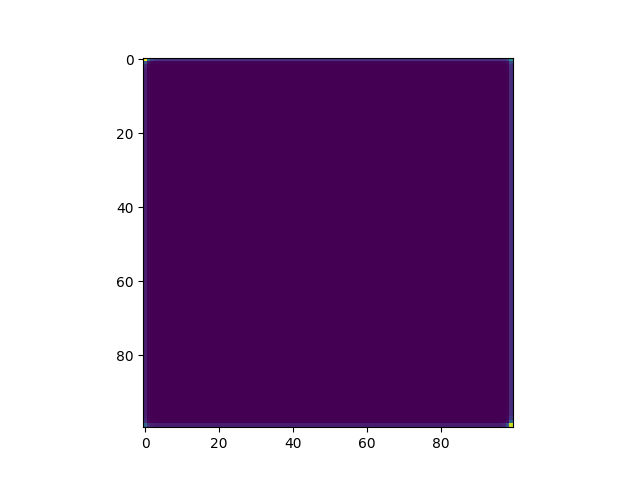

In [97]:
with torch.no_grad():
    plt.figure()
    plt.imshow(primer[1][1][6])
    plt.show()

    plt.figure()
    plt.imshow(mreza(primer[0][1])[6])
    plt.show()

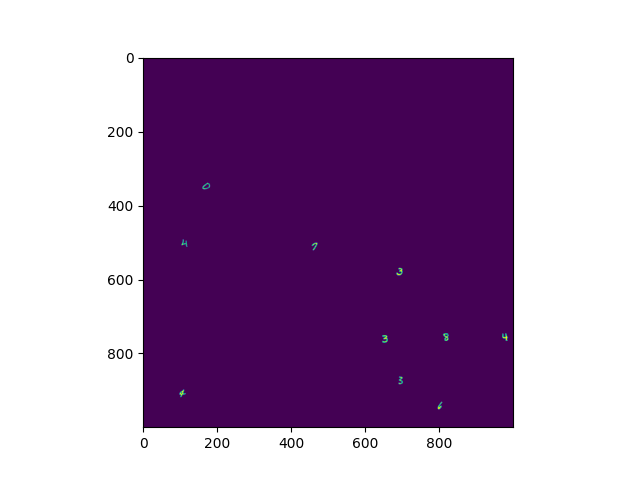

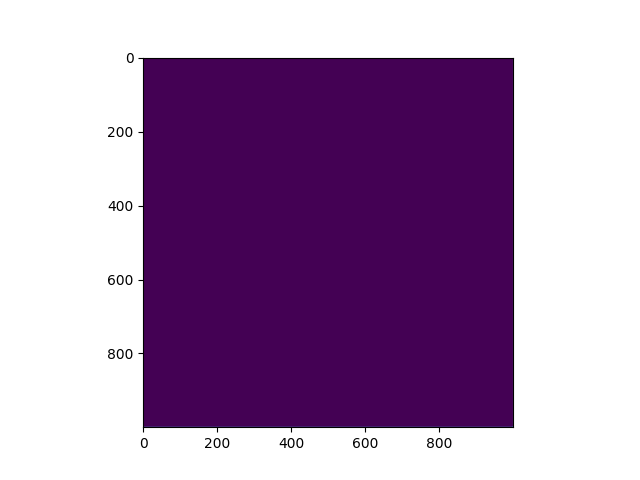

In [99]:
velika_slika = np.zeros((1, 1000, 1000))

# cifre = next(iter(mnist_trening_podaci))

male_slike = np.random.choice(len(slike_trening), 10)

koordinate = np.random.randint(0, 1000-28, size=(10, 2))

for i, c in enumerate(male_slike):
    velika_slika[0][koordinate[i][0]:koordinate[i][0]+28, koordinate[i][1]:koordinate[i][1]+28,] = slike_trening[c]

plt.figure()
plt.imshow(velika_slika[0])
plt.show()


with torch.no_grad():
    plt.figure()
    plt.imshow(mreza(torch.from_numpy(velika_slika.astype(np.float32)))[0])
    plt.show()